## **Importing Required Libraries**

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.filterwarnings("ignore")
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

## **Data Loading and Dataset Overview**

In [4]:
print("Loading data...")
books = pd.read_csv("books.csv")

Loading data...


## **Basic initial exploration**

In [6]:
print(f"\n Dataset shape: {books.shape}")
print(f"\n Columns in dataset:\n{books.columns.tolist()}")
print(f"\n Data types and missing values:\n")
print(books.info())
print(f"\n Basic statistics:\n{books.describe().round(2)}")

books.head(5)


 Dataset shape: (10000, 23)

 Columns in dataset:
['book_id', 'goodreads_book_id', 'best_book_id', 'work_id', 'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year', 'original_title', 'title', 'language_code', 'average_rating', 'ratings_count', 'work_ratings_count', 'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url', 'small_image_url']

 Data types and missing values:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    10000 non-null  int64  
 1   goodreads_book_id          10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


## Creating target variable before cleaning

In [8]:
books_temp = books.copy()
books_temp = books_temp.dropna(subset=['ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'ratings_count'])
target = (books_temp["ratings_4"] + books_temp["ratings_5"]) / books_temp["ratings_count"]
target = target.clip(0, 1)
print(f"\nTarget: Proportion of High Ratings (4 Star + 5 Star)")
print(f"  Mean: {target.mean():.4f}")
print(f"  Median: {target.median():.4f}")
print(f"  Std: {target.std():.4f}")
print(f"  Min: {target.min():.4f}")
print(f"  Max: {target.max():.4f}")
print(f"  25th percentile: {target.quantile(0.25):.4f}")
print(f"  75th percentile: {target.quantile(0.75):.4f}")

 


Target: Proportion of High Ratings (4 Star + 5 Star)
  Mean: 0.8040
  Median: 0.8054
  Std: 0.1211
  Min: 0.2033
  Max: 1.0000
  25th percentile: 0.7281
  75th percentile: 0.8865


## **Exploratory Data Analysis**

##  Clean data for analysis

In [11]:
required_cols = [
    "average_rating", "authors", "title", "original_publication_year",
    "ratings_1", "ratings_2", "ratings_3", "ratings_4", "ratings_5",
    "ratings_count", "work_ratings_count",
    "work_text_reviews_count", "books_count"
]
books_clean = books.dropna(subset=required_cols)
print(f"\n After removing missing values: {books_clean.shape[0]} rows")


 After removing missing values: 9979 rows


## Rating distribution analysis

In [13]:
print("\n Rating Distribution Statistics")
rating_cols = ['ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']
for col in rating_cols:
    print(f"{col}: Mean={books_clean[col].mean():.0f}, Median={books_clean[col].median():.0f}, Max={books_clean[col].max():.0f}")


 Rating Distribution Statistics
ratings_1: Mean=1346, Median=391, Max=456191
ratings_2: Mean=3115, Median=1164, Max=436802
ratings_3: Mean=11489, Median=4897, Max=793319
ratings_4: Mean=19990, Median=8275, Max=1481305
ratings_5: Mean=23803, Median=8838, Max=3011543


## Average rating analysis

In [15]:
print("\n Average Rating Distribution ")
print(f"  Mean: {books_clean['average_rating'].mean():.2f}")
print(f"  Median: {books_clean['average_rating'].median():.2f}")
print(f"  Min: {books_clean['average_rating'].min():.2f}")
print(f"  Max: {books_clean['average_rating'].max():.2f}")


 Average Rating Distribution 
  Mean: 4.00
  Median: 4.02
  Min: 2.47
  Max: 4.82


## Correlation analysis

In [17]:
print("\n Feature Correlations with Target")
y_clean = (books_clean["ratings_4"] + books_clean["ratings_5"]) / books_clean["ratings_count"]
numeric_cols = ['average_rating', 'ratings_count', 'work_ratings_count', 
                'work_text_reviews_count', 'books_count', 'original_publication_year']
correlations = []
for col in numeric_cols:
    corr = books_clean[col].corr(y_clean)
    correlations.append((col, corr))
correlations.sort(key=lambda x: abs(x[1]), reverse=True)
for col, corr in correlations:
    print(f"  {col:30s}: {corr:+.4f}")
    
print(f"\nDataset Shape: {books.shape}")


 Feature Correlations with Target
  average_rating                : +0.5602
  work_text_reviews_count       : +0.0547
  ratings_count                 : -0.0260
  books_count                   : +0.0062
  original_publication_year     : +0.0026
  work_ratings_count            : +0.0004

Dataset Shape: (10000, 23)


## Distribution of Average Ratings

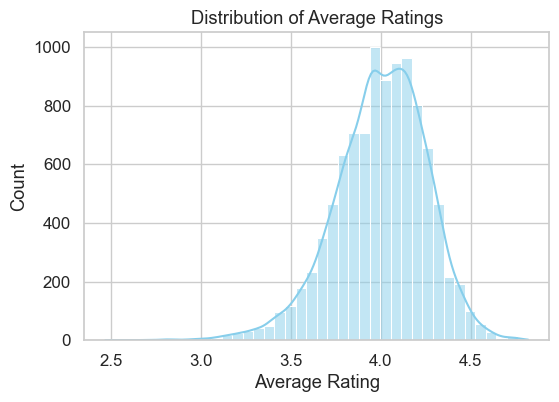

In [19]:
plt.figure(figsize=(6,4))
sns.histplot(books['average_rating'], bins=40, kde=True, color='skyblue')
plt.title("Distribution of Average Ratings")
plt.xlabel("Average Rating")
plt.ylabel("Count")
plt.show()

## Ratings Count & Reviews Count

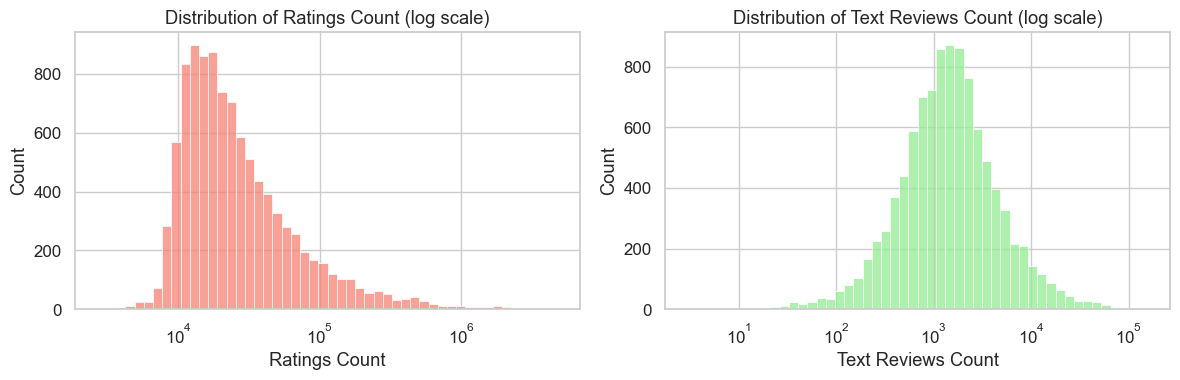

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.histplot(books['ratings_count'], bins=50, log_scale=True, color='salmon', ax=axes[0])
axes[0].set_title("Distribution of Ratings Count (log scale)")
axes[0].set_xlabel("Ratings Count")

sns.histplot(books['work_text_reviews_count'], bins=50, log_scale=True, color='lightgreen', ax=axes[1])
axes[1].set_title("Distribution of Text Reviews Count (log scale)")
axes[1].set_xlabel("Text Reviews Count")

plt.tight_layout()
plt.show()

## Author Activity

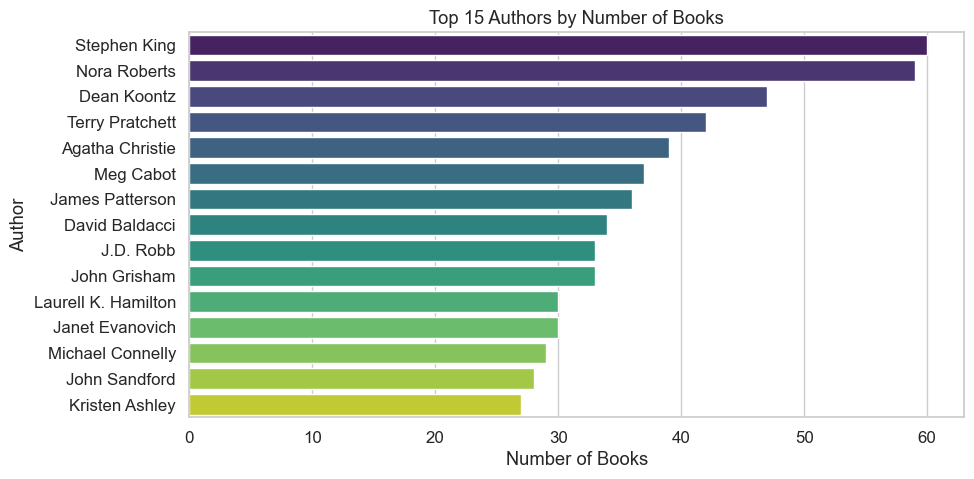

In [23]:
top_authors = books['authors'].value_counts().head(15)

plt.figure(figsize=(10,5))
sns.barplot(x=top_authors.values, y=top_authors.index, palette="viridis")
plt.title("Top 15 Authors by Number of Books")
plt.xlabel("Number of Books")
plt.ylabel("Author")
plt.show()


## Temporal Analysis (Publication Year)

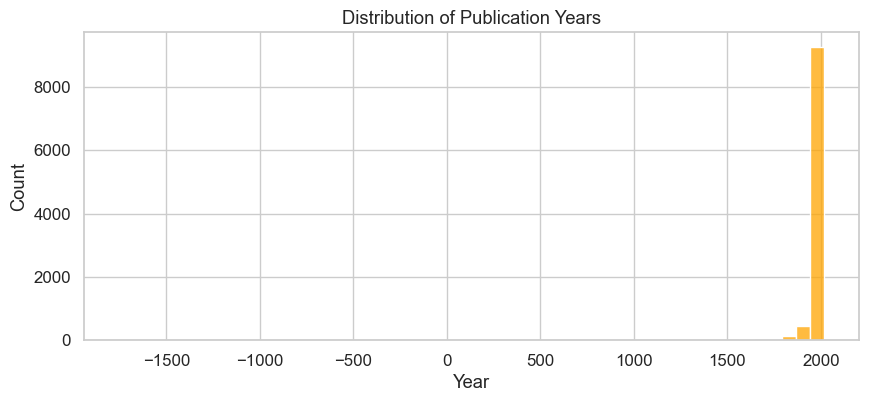

In [25]:
plt.figure(figsize=(10,4))
sns.histplot(books['original_publication_year'], bins=50, color='orange')
plt.title("Distribution of Publication Years")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

## Correlation Heatmap

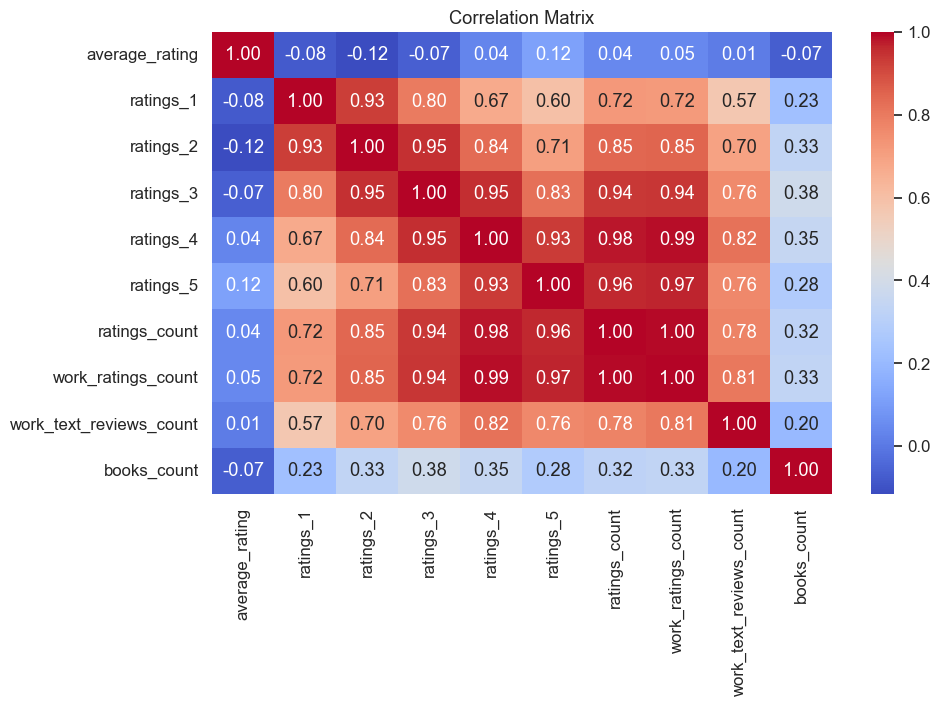

In [27]:
numeric_cols = [
    "average_rating", "ratings_1", "ratings_2", "ratings_3", "ratings_4", "ratings_5",
    "ratings_count", "work_ratings_count", "work_text_reviews_count", "books_count"
]

plt.figure(figsize=(10,6))
sns.heatmap(books[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## Average Rating vs Ratings Count

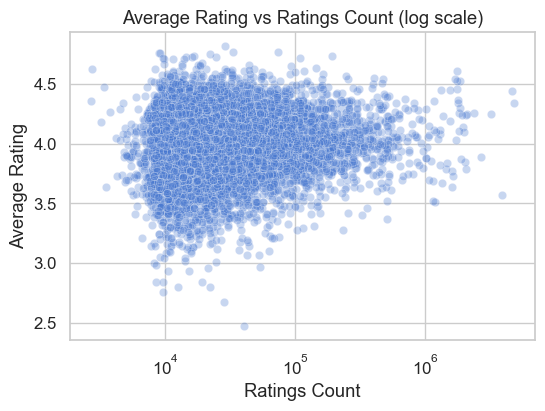

In [29]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='ratings_count', y='average_rating', data=books, alpha=0.3)
plt.xscale("log")
plt.title("Average Rating vs Ratings Count (log scale)")
plt.xlabel("Ratings Count")
plt.ylabel("Average Rating")
plt.show()

## **DATA PREPARATION FOR MODELING**

In [31]:
y = (books_clean["ratings_4"] + books_clean["ratings_5"]) / books_clean["ratings_count"]
y = y.clip(0, 1)
X = books_clean.drop(columns=["average_rating"])

print(f" Features shape: {X.shape}")
print(f" Target shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"\n Training set: {X_train.shape[0]} samples")
print(f" Test set: {X_test.shape[0]} samples")

 Features shape: (9979, 22)
 Target shape: (9979,)

 Training set: 7983 samples
 Test set: 1996 samples


## **Author Distribution & Feature Engineering**

## Computing Author Stats

In [34]:
def compute_author_stats(X_train, y_train):
    train_data = X_train.copy()
    train_data["rating_signal"] = y_train.values
    rating_cols = ["ratings_1", "ratings_2", "ratings_3", "ratings_4", "ratings_5"]
    stats = []
    for author, group in train_data.groupby("authors"):
        dist = group[rating_cols].sum()
        total = dist.sum()
        if total > 0:
            pcts = dist / total
            high_pct = pcts["ratings_4"] + pcts["ratings_5"]
            low_pct = pcts["ratings_1"] + pcts["ratings_2"]
            stats.append({
                "authors": author,
                "auth_pct_1star": pcts["ratings_1"],
                "auth_pct_2star": pcts["ratings_2"],
                "auth_pct_3star": pcts["ratings_3"],
                "auth_pct_4star": pcts["ratings_4"],
                "auth_pct_5star": pcts["ratings_5"],
                "auth_high_pct": high_pct,
                "auth_low_pct": low_pct,
                "auth_skew": high_pct - low_pct,
                "auth_book_count": len(group),
                "auth_mean_rating": group["rating_signal"].mean(),
                "auth_std_rating": group["rating_signal"].std() if len(group) > 1 else 0
            })
    author_stats = pd.DataFrame(stats)
    C = y_train.mean()
    m = 15
    author_stats["auth_bayesian_rating"] = (
        (author_stats["auth_book_count"] * author_stats["auth_mean_rating"] + m * C) /
        (author_stats["auth_book_count"] + m)
    )
    global_stats = {
        "mean": C,
        "pct_1": author_stats["auth_pct_1star"].mean(),
        "pct_2": author_stats["auth_pct_2star"].mean(),
        "pct_3": author_stats["auth_pct_3star"].mean(),
        "pct_4": author_stats["auth_pct_4star"].mean(),
        "pct_5": author_stats["auth_pct_5star"].mean()
    }
    return author_stats, global_stats

## Feature Engineering

In [36]:
def create_features(df, author_stats=None, global_stats=None):
    data = df.copy()
    
    # Log transforms
    data["log_ratings_count"] = np.log1p(data["ratings_count"])
    data["log_work_ratings"] = np.log1p(data["work_ratings_count"])
    data["log_text_reviews"] = np.log1p(data["work_text_reviews_count"])
    data["log_books_count"] = np.log1p(data["books_count"])
    
    # Time features
    data["years_since_pub"] = 2026 - data["original_publication_year"]
    data["log_age"] = np.log1p(data["years_since_pub"].clip(0))
    
    # Series features
    data["series_num"] = data["title"].apply(
        lambda x: int(re.search(r"#\s*(\d+)", str(x)).group(1))
        if re.search(r"#\s*(\d+)", str(x)) else 1
    )
    data["is_series"] = (data["series_num"] > 1).astype(int)
    
    # Rating distribution insights
    rating_cols = ["ratings_1", "ratings_2", "ratings_3", "ratings_4", "ratings_5"]
    total_ratings = data[rating_cols].sum(axis=1)
    
    for i, col in enumerate(rating_cols, 1):
        data[f"pct_{i}star"] = data[col] / (total_ratings + 1)
    
    data["rating_variance"] = data[[f"pct_{i}star" for i in range(1, 6)]].var(axis=1)
    data["high_rating_ratio"] = (data["ratings_5"] + data["ratings_4"]) / (total_ratings + 1)
    data["low_rating_ratio"] = (data["ratings_1"] + data["ratings_2"]) / (total_ratings + 1)
    data["rating_polarization"] = data["pct_5star"] + data["pct_1star"]
    
    # Review engagement
    data["reviews_per_rating"] = data["work_text_reviews_count"] / (data["ratings_count"] + 1)
    data["work_to_rating_ratio"] = data["work_ratings_count"] / (data["ratings_count"] + 1)
    
    # Polynomial features
    data["log_ratings_sq"] = data["log_ratings_count"] ** 2
    data["log_age_sq"] = data["log_age"] ** 2
    
    # Interaction features
    data["age_x_popularity"] = data["log_age"] * data["log_ratings_count"]
    data["reviews_x_books"] = data["log_text_reviews"] * data["log_books_count"]
    
    if author_stats is not None:
        data = data.merge(author_stats, on="authors", how="left")
        for i in range(1, 6):
            col = f"auth_pct_{i}star"
            data[col] = data[col].fillna(global_stats[f"pct_{i}"])
        data.fillna({
            "auth_high_pct": 0.6,
            "auth_low_pct": 0.2,
            "auth_skew": 0.4,
            "auth_book_count": 1,
            "auth_mean_rating": global_stats["mean"],
            "auth_std_rating": 0.2,
            "auth_bayesian_rating": global_stats["mean"]
        }, inplace=True)
    
    return data

## Computing Author Stats on Training Data

In [38]:
author_stats, global_stats = compute_author_stats(X_train, y_train)
print(f" Computed statistics for {len(author_stats)} authors")


 Computed statistics for 3993 authors


## Create features

In [40]:
X_train_fe = create_features(X_train, author_stats, global_stats)
X_test_fe = create_features(X_test, author_stats, global_stats)
print(f" Features after engineering: {X_train_fe.shape[1]} columns")

 Features after engineering: 57 columns


## **Feature Preprocessing**

## Preprocessor Pipeline

In [43]:
def author_tokenizer(text):
    return [a.strip() for a in str(text).split(",")]

numeric_features = X_train_fe.select_dtypes(include=np.number).columns.tolist()

preprocessor_lr = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), numeric_features),
    ("title", TfidfVectorizer(
        max_features=400,
        ngram_range=(1, 2),
        min_df=3,
        stop_words="english",
        sublinear_tf=True
    ), "title"),
    ("authors", TfidfVectorizer(
        tokenizer=author_tokenizer,
        token_pattern=None,
        max_features=300,
        min_df=2,
        sublinear_tf=True
    ), "authors")
])

preprocessor_tree = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("quantile", QuantileTransformer(
            output_distribution="normal", random_state=42
        ))
    ]), numeric_features),
    ("title", TfidfVectorizer(
        max_features=400,
        ngram_range=(1, 2),
        min_df=3,
        stop_words="english",
        sublinear_tf=True
    ), "title"),
    ("authors", TfidfVectorizer(
        tokenizer=author_tokenizer,
        token_pattern=None,
        max_features=300,
        min_df=2,
        sublinear_tf=True
    ), "authors")
])

preprocessor_tree

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('title', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``.

In [44]:
preprocessor_lr

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('title', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``.

## **Model Definitions**

## Initializing Regression Models

In [47]:
models = {
    "Linear Regression": (LinearRegression(), preprocessor_lr),
    "Ridge": (Ridge(alpha=5), preprocessor_lr),
    "Random Forest": (RandomForestRegressor(
        n_estimators=600,
        max_depth=25,
        min_samples_split=3,
        min_samples_leaf=1,
        max_features=0.7,
        random_state=42,
        n_jobs=-1
    ), preprocessor_tree),
    "Gradient Boosting": (GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.85,
        max_features=0.8,
        random_state=42
    ), preprocessor_tree),
    "XGBoost": (XGBRegressor(
        n_estimators=1000,
        learning_rate=0.02,
        max_depth=7,
        min_child_weight=3,
        subsample=0.85,
        colsample_bytree=0.85,
        colsample_bylevel=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        gamma=0.02,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,
        tree_method='hist'
    ), preprocessor_tree)
}

## **Model Training and Evaluation**

In [49]:
results = {}
predictions = {}
for name, (model, preprocessor) in models.items():
    print(f"\nTraining {name}...")
    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train_fe, y_train)
    
    y_train_pred = pipe.predict(X_train_fe).clip(0, 1)
    train_r2 = r2_score(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    
    y_test_pred = pipe.predict(X_test_fe).clip(0, 1)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    r2_gap = train_r2 - test_r2
    mae_gap = test_mae - train_mae
    rmse_gap = test_rmse - train_rmse
    
    results[name] = {
        "Train_R²": train_r2,
        "Test_R²": test_r2,
        "R²_Gap": r2_gap,
        "Train_MAE": train_mae,
        "Test_MAE": test_mae,
        "MAE_Gap": mae_gap,
        "Train_RMSE": train_rmse,
        "Test_RMSE": test_rmse,
        "RMSE_Gap": rmse_gap
    }
    predictions[name] = y_test_pred
    print(f" Test R²: {test_r2:.4f} | MAE: {test_mae:.4f} | RMSE: {test_rmse:.4f}")

results_df = pd.DataFrame(results).T.sort_values("Test_R²", ascending=False)

print("\n" + "="*80)
print("FINAL RESULTS: TRAINING vs TEST PERFORMANCE")
print("="*80)
print("\nR² Scores:")
print(results_df[["Train_R²", "Test_R²", "R²_Gap"]].round(4))
print("\nMAE Scores:")
print(results_df[["Train_MAE", "Test_MAE", "MAE_Gap"]].round(4))
print("\nRMSE Scores:")
print(results_df[["Train_RMSE", "Test_RMSE", "RMSE_Gap"]].round(4))


Training Linear Regression...
 Test R²: 0.9347 | MAE: 0.0211 | RMSE: 0.0304

Training Ridge...
 Test R²: 0.8699 | MAE: 0.0309 | RMSE: 0.0429

Training Random Forest...
 Test R²: 0.9694 | MAE: 0.0115 | RMSE: 0.0208

Training Gradient Boosting...
 Test R²: 0.9866 | MAE: 0.0072 | RMSE: 0.0138

Training XGBoost...
 Test R²: 0.9570 | MAE: 0.0157 | RMSE: 0.0247

FINAL RESULTS: TRAINING vs TEST PERFORMANCE

R² Scores:
                   Train_R²  Test_R²  R²_Gap
Gradient Boosting    0.9997   0.9866  0.0131
Random Forest        0.9993   0.9694  0.0299
XGBoost              0.9938   0.9570  0.0368
Linear Regression    0.9800   0.9347  0.0453
Ridge                0.9662   0.8699  0.0963

MAE Scores:
                   Train_MAE  Test_MAE  MAE_Gap
Gradient Boosting     0.0016    0.0072   0.0056
Random Forest         0.0016    0.0115   0.0099
XGBoost               0.0061    0.0157   0.0096
Linear Regression     0.0101    0.0211   0.0110
Ridge                 0.0140    0.0309   0.0169

RMSE Scores:

In [50]:
predicted_table = results_df[
    ["Test_R²", "Test_MAE", "Test_RMSE"]
].round(4)

predicted_table.columns = ["R²", "MAE", "RMSE"]

print("\n" + "="*60)
print("PREDICTED PERFORMANCE (TEST SET)")
print("="*60)
print(predicted_table)



PREDICTED PERFORMANCE (TEST SET)
                       R²     MAE    RMSE
Gradient Boosting  0.9866  0.0072  0.0138
Random Forest      0.9694  0.0115  0.0208
XGBoost            0.9570  0.0157  0.0247
Linear Regression  0.9347  0.0211  0.0304
Ridge              0.8699  0.0309  0.0429


## **OVERFITTING ANALYSIS**

In [52]:
for model_name in results_df.index:
    r2_gap = results_df.loc[model_name, "R²_Gap"]
    if r2_gap < 0.05:
        status = " NO OVERFITTING - Good generalization"
    elif r2_gap < 0.10:
        status = " SLIGHT OVERFITTING - Acceptable"
    elif r2_gap < 0.20:
        status = " MODERATE OVERFITTING - Needs attention"
    else:
        status = " SEVERE OVERFITTING - Major issue"
    print(f"{model_name:20s} | R² Gap: {r2_gap:6.4f} | {status}")
print("="*80)

Gradient Boosting    | R² Gap: 0.0131 |  NO OVERFITTING - Good generalization
Random Forest        | R² Gap: 0.0299 |  NO OVERFITTING - Good generalization
XGBoost              | R² Gap: 0.0368 |  NO OVERFITTING - Good generalization
Linear Regression    | R² Gap: 0.0453 |  NO OVERFITTING - Good generalization
Ridge                | R² Gap: 0.0963 |  SLIGHT OVERFITTING - Acceptable


## **Model Visualization**

## Defining Visualization Functions

In [55]:
def plot_pred_vs_actual(y_true, y_pred, model_name):
    # Convert proportions (0-1) back to rating scale (1-5)
    y_true_stars = y_true * 4 + 1  # Maps 0->1, 1->5
    y_pred_stars = y_pred * 4 + 1
    
    # Check for out-of-bounds predictions
    out_of_bounds = (y_pred_stars < 1) | (y_pred_stars > 5)
    if out_of_bounds.any():
        print(f"  {model_name}: {out_of_bounds.sum()} predictions out of [1,5] range")
        print(f"    Min: {y_pred_stars.min():.3f}, Max: {y_pred_stars.max():.3f}")
    
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true_stars, y_pred_stars, alpha=0.3, s=20)
    plt.plot([1, 5], [1, 5], 'r--', linewidth=2, label='Perfect Prediction')
    plt.xlabel("Actual Rating", fontsize=12)
    plt.ylabel("Predicted Rating", fontsize=12)
    plt.title(f"Predicted vs Actual — {model_name}", fontsize=13, fontweight='bold')
    
    # Set limits with some padding to show any out-of-bounds points
    plt.xlim(0.8, 5.2)
    plt.ylim(0.8, 5.2)
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true.values - y_pred
    plt.figure(figsize=(7, 4))
    plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    plt.title(f"Residual Distribution — {model_name}", fontsize=13, fontweight='bold')
    plt.xlabel("Residual (Actual - Predicted)", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

def plot_residuals_vs_pred(y_pred, y_true, model_name):
    residuals = y_true.values - y_pred
    plt.figure(figsize=(7, 4))
    plt.scatter(y_pred, residuals, alpha=0.3, s=20)
    plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    plt.xlabel("Predicted Rating", fontsize=12)
    plt.ylabel("Residual", fontsize=12)
    plt.title(f"Residuals vs Predicted — {model_name}", fontsize=13, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

def plot_error_tolerance(y_true, y_pred, model_name):
    thresholds = np.linspace(0, 1.5, 30)
    within = [
        np.mean(np.abs(y_true.values - y_pred) <= t)
        for t in thresholds
    ]
    plt.figure(figsize=(6, 4))
    plt.plot(thresholds, within, linewidth=2)
    plt.xlabel("Error Tolerance (Stars)", fontsize=12)
    plt.ylabel("Fraction Within Tolerance", fontsize=12)
    plt.title(f"Error Tolerance Curve — {model_name}", fontsize=13, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

def plot_metric_comparison(results_df):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # MAE and RMSE comparison
    results_df[["Test_MAE", "Test_RMSE"]].plot(kind="bar", ax=axes[0], edgecolor='black')
    axes[0].set_title("Model Error Comparison (Lower is Better)", fontsize=13, fontweight='bold')
    axes[0].set_ylabel("Error", fontsize=12)
    axes[0].set_xlabel("")
    axes[0].tick_params(axis='x', rotation=30)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # R² comparison
    results_df["Test_R²"].plot(kind="bar", ax=axes[1], color='green', edgecolor='black')
    axes[1].set_title("R² Comparison (Higher is Better)", fontsize=13, fontweight='bold')
    axes[1].set_ylabel("R² Score", fontsize=12)
    axes[1].set_xlabel("")
    axes[1].tick_params(axis='x', rotation=30)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()

## Generating Plots for All Models


GENERATING VISUALIZATIONS

Generating plots for each model...


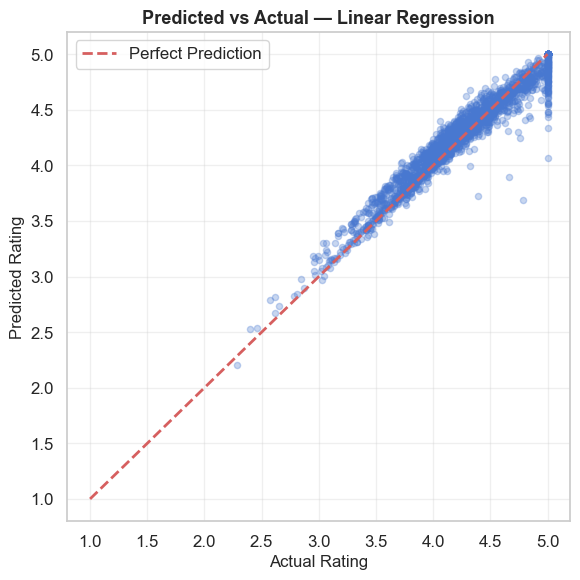

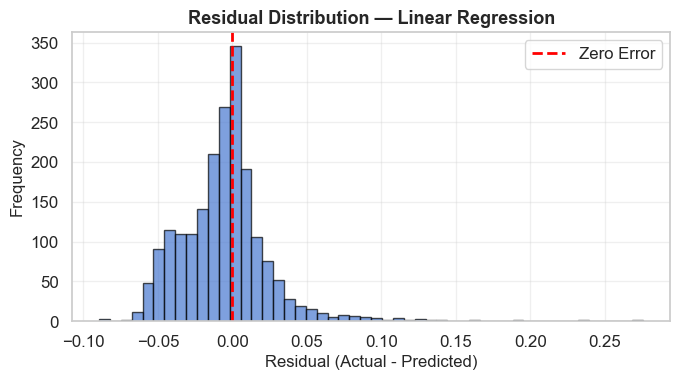

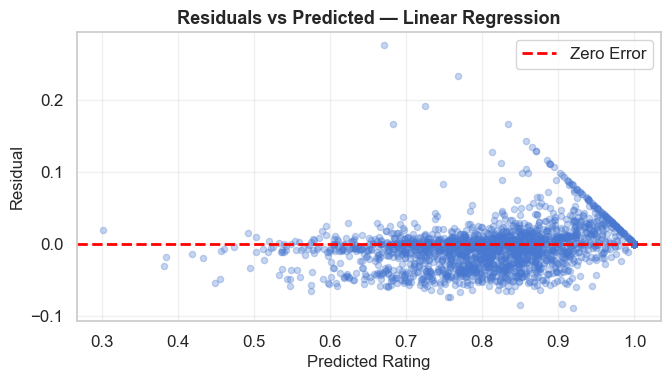

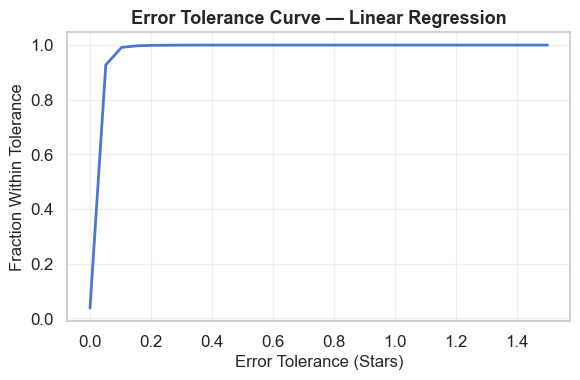

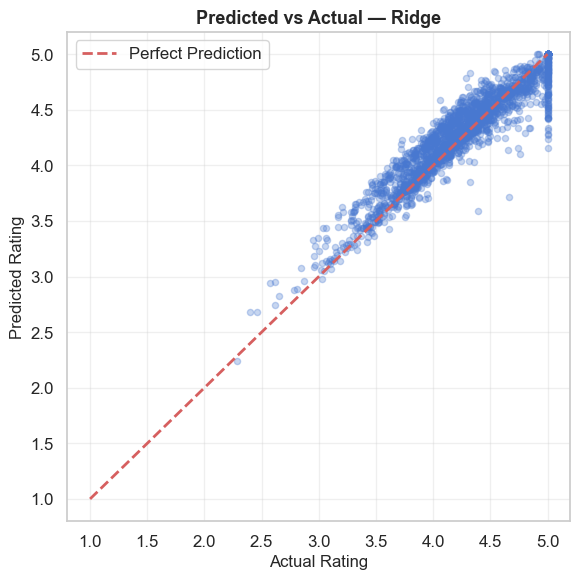

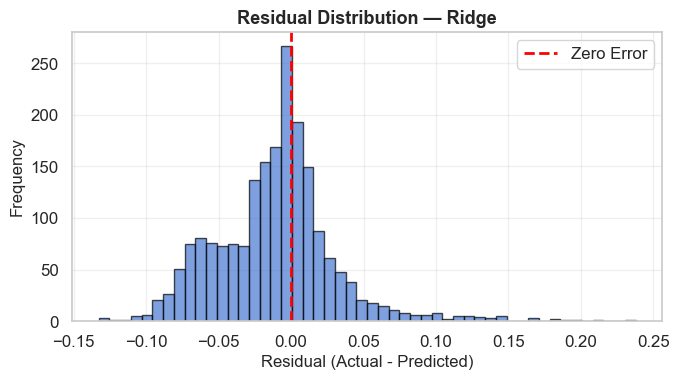

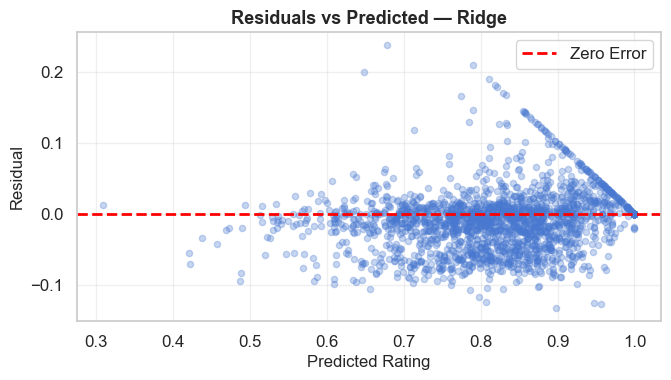

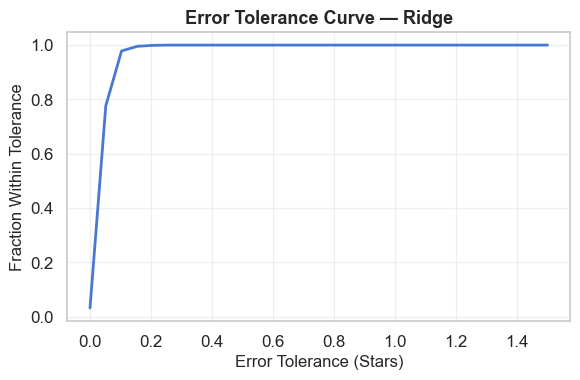

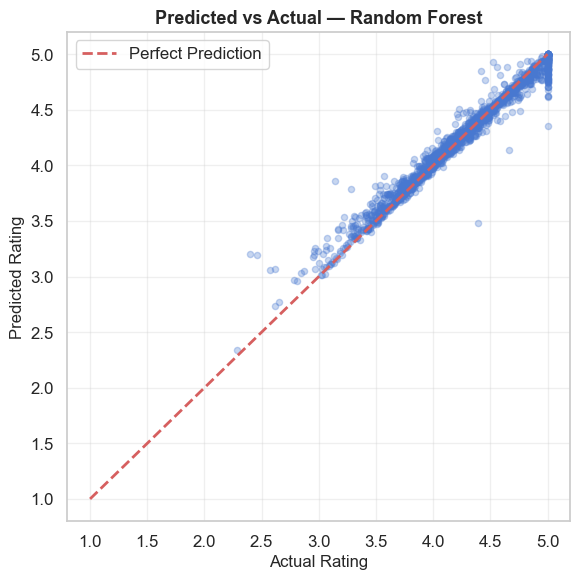

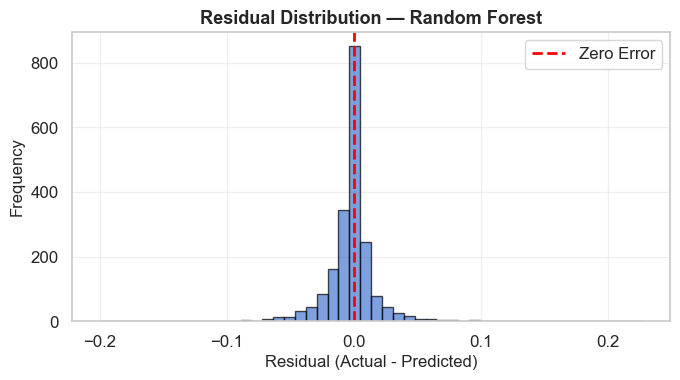

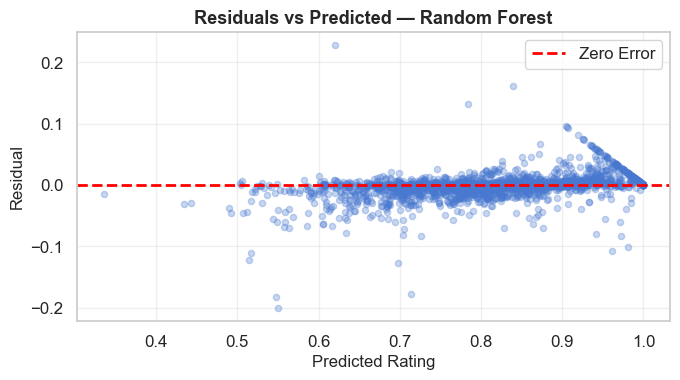

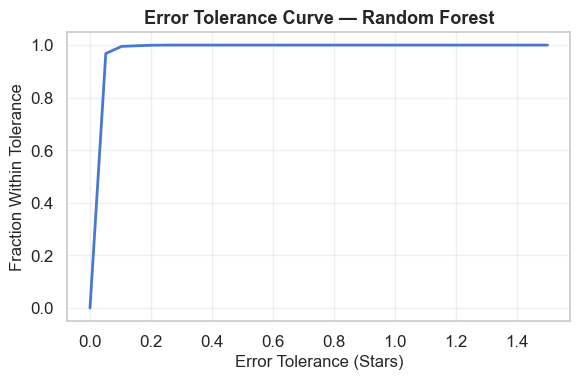

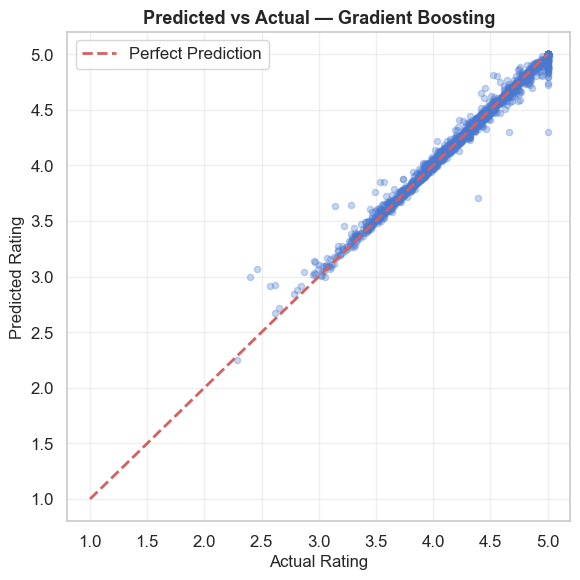

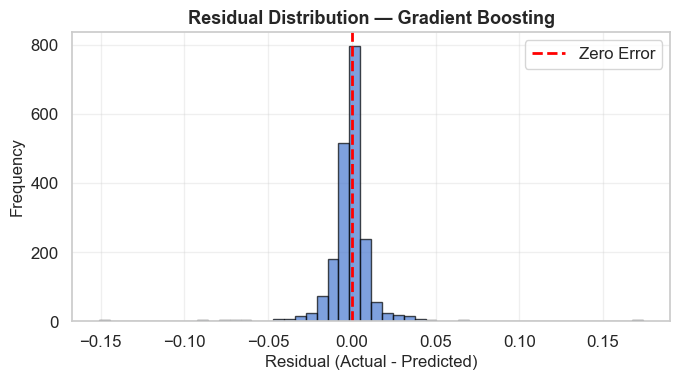

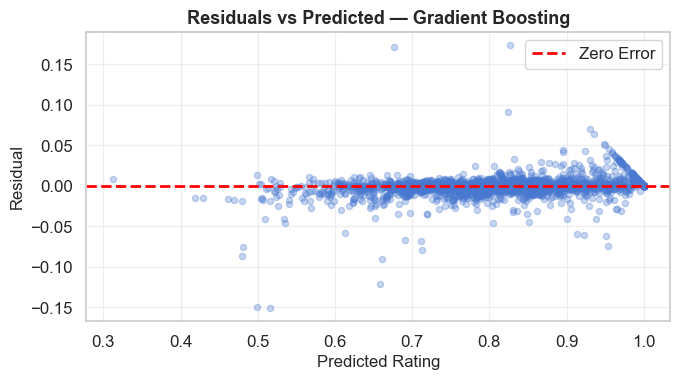

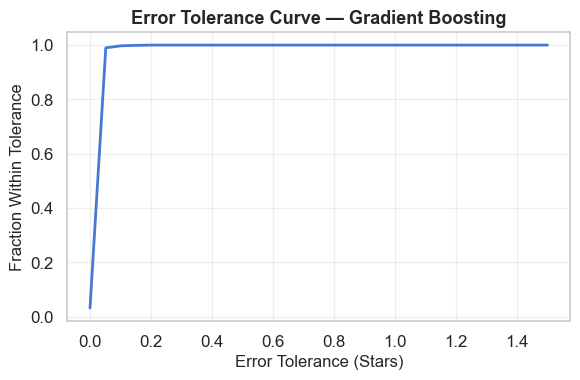

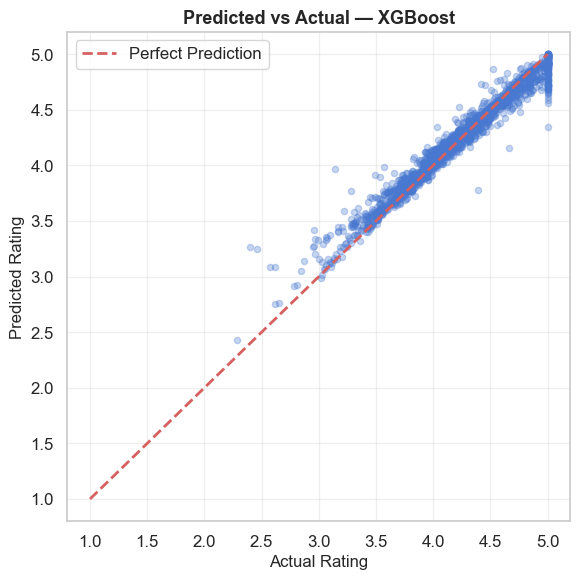

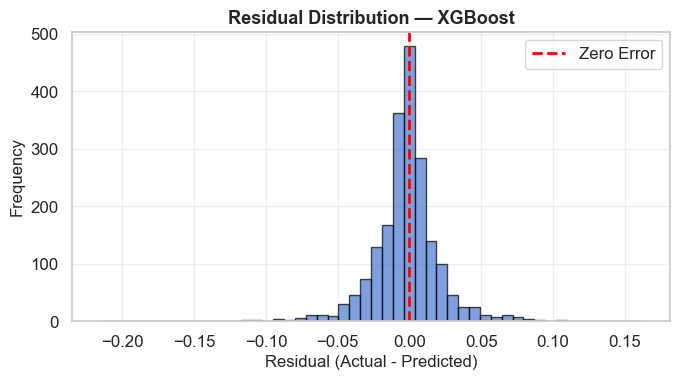

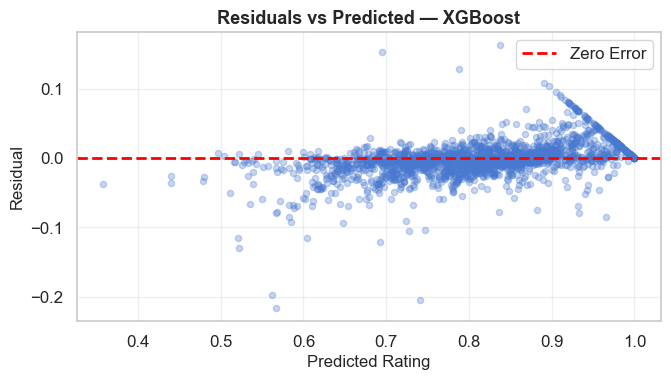

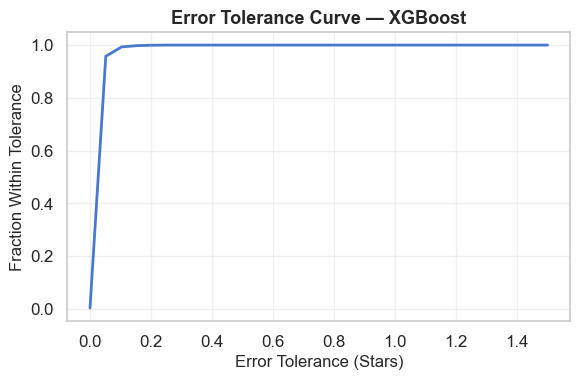

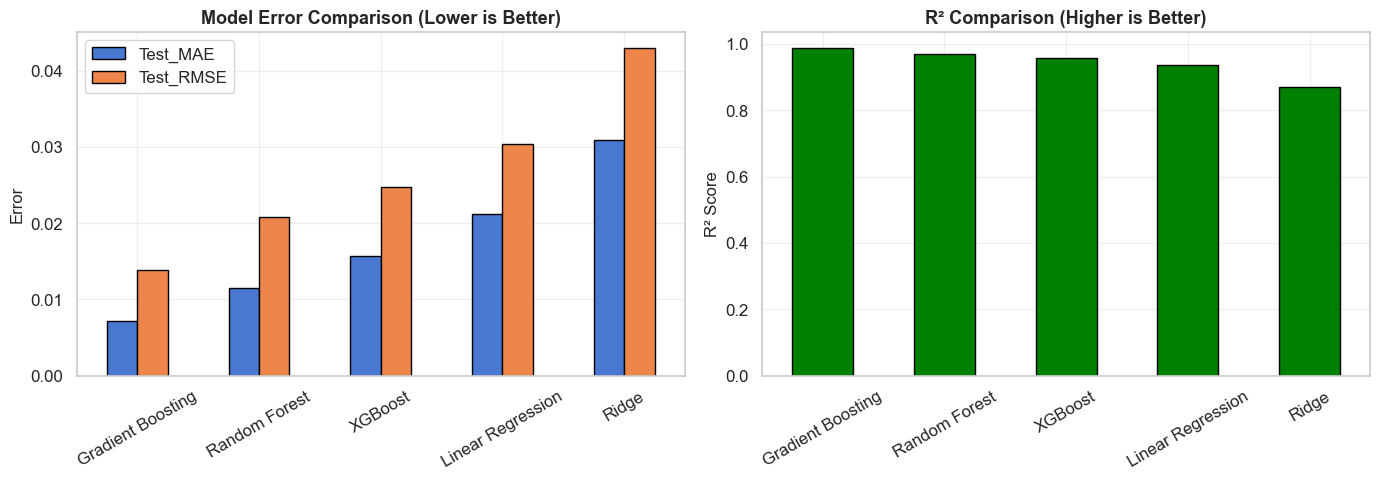

In [57]:
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80 + "\n")

print("Generating plots for each model...")
for name, y_pred in predictions.items():
    plot_pred_vs_actual(y_test, y_pred, name)
    plot_residuals(y_test, y_pred, name)
    plot_residuals_vs_pred(y_pred, y_test, name)
    plot_error_tolerance(y_test, y_pred, name)

plot_metric_comparison(results_df)
print("="*80)


3. Generating Overfitting Analysis...


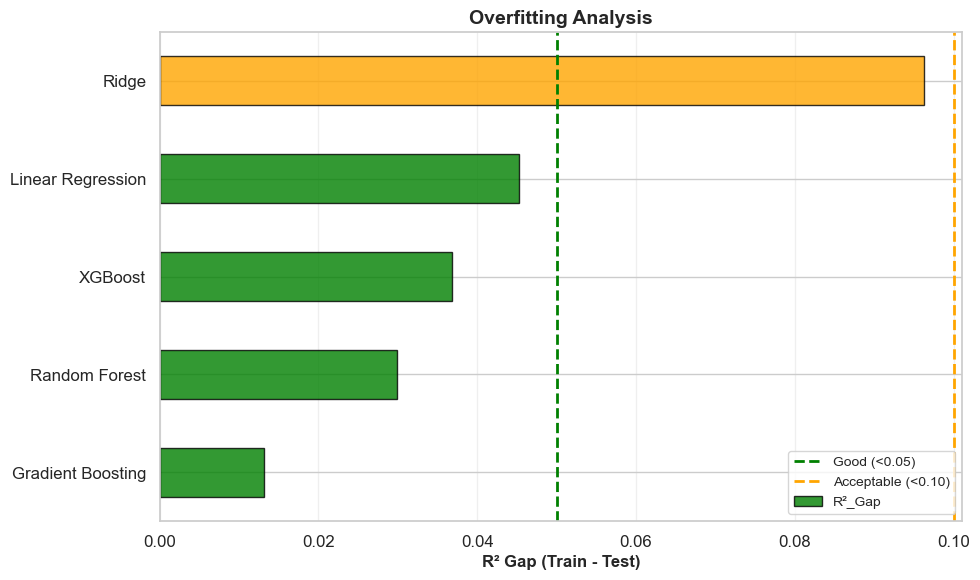

In [58]:
print("\n3. Generating Overfitting Analysis...")
plt.figure(figsize=(10, 6))
colors = ['green' if gap < 0.05 else 'orange' if gap < 0.10 else 'red' 
          for gap in results_df['R²_Gap']]
results_df['R²_Gap'].plot(kind='barh', color=colors, edgecolor='black', alpha=0.8)
plt.xlabel('R² Gap (Train - Test)', fontsize=12, fontweight='bold')
plt.title('Overfitting Analysis', fontsize=14, fontweight='bold')
plt.axvline(0.05, color='green', linestyle='--', linewidth=2, label='Good (<0.05)')
plt.axvline(0.10, color='orange', linestyle='--', linewidth=2, label='Acceptable (<0.10)')
plt.legend(fontsize=10, loc='lower right')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [88]:
pip list > requirement.txt

Note: you may need to restart the kernel to use updated packages.
